In [1]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

Definition of the Distance Matrix

In [2]:
n_robots = int(input("number of robots: "))
platoon = []

# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]
S = []
for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

for i in range(len(coordinates[1])):
    S.append([coordinates[0,i], coordinates[1,i]])
S = np.array(S)

DM = d_matrix(platoon)
print(DM)

[[ 0.          6.38313497 10.56124395]
 [ 6.38313497  0.          8.29273514]
 [10.56124395  8.29273514  0.        ]]


Identity matrix

In [3]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Definition of the e vector and the H matrix

In [4]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


Eigendecomposition of the matrix -1/2*H*D*H

In [5]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.35461861 -0.58673578]
 [-0.35461861 -0.         -0.46070751]
 [-0.58673578 -0.46070751 -0.        ]] 

[[-0.94124804  0.          0.        ]
 [-0.          0.60405464  0.        ]
 [-0.          0.          0.3371934 ]] 

 [[ 0.58396247  0.52363397  0.62031871]
 [ 0.60837489  0.22362885 -0.76149204]
 [ 0.53746426 -0.8220691   0.1879749 ]]


Scikit learn MDS approach

In [6]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,n_init = 20,max_iter = 1000,random_state = 73073,dissimilarity='precomputed') # instantiate and set the hyperparameter
MDS_transformed = embedding.fit_transform(DM)
MDS_transformed.shape
print(MDS_transformed)
print(S)

[[ 4.61541827  2.21922363]
 [ 1.26105479 -3.21577322]
 [-5.87647305  0.99654959]]
[[0.         0.        ]
 [6.36059761 0.53591989]
 [5.82261719 8.81118624]]


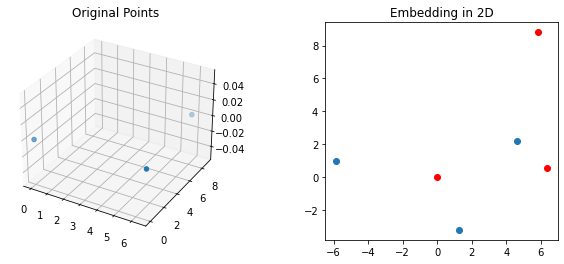

In [7]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(MDS_transformed[:,0], MDS_transformed[:,1])
plt.scatter(S[:,0], S[:,1], color='red')
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

Introduction of the controlled displacement

In [8]:
deltaX = deltaY = 0.1

deltaSprime = np.array([[0,0] for i in range(n_robots)],dtype=float)
deltaSprime[0] = [deltaX,deltaY]
print(deltaSprime)

Sprime = S + deltaSprime
print(Sprime)

[[0.1 0.1]
 [0.  0. ]
 [0.  0. ]]
[[0.1        0.1       ]
 [6.36059761 0.53591989]
 [5.82261719 8.81118624]]


Phi prime definition

In [9]:
Phiprime = np.array([np.diag(Sprime@np.transpose(Sprime))]).T
print(Phiprime)

DMprime = Phiprime@e.T - 2*Sprime@Sprime.T + e@Phiprime.T
print(DMprime)

[[2.00000000e-02]
 [4.07444120e+01]
 [1.11539874e+02]]
[[  0.          39.38510854 108.63311317]
 [ 39.38510854   0.          68.7694561 ]
 [108.63311317  68.7694561    0.        ]]


DMprime breakdown analysis (as on the paper)

In [10]:
piece1 = DM - DMprime
print(piece1)

piece2 = (np.ones(n_robots)-np.eye(n_robots))*(0.1**2*2)
print(piece2)

piece3 = -2*((S@deltaSprime.T).T + S@deltaSprime.T)
print(piece3)

print(piece1+piece2+piece3)

[[  0.         -33.00197357 -98.07186921]
 [-33.00197357   0.         -60.47672096]
 [-98.07186921 -60.47672096   0.        ]]
[[0.   0.02 0.02]
 [0.02 0.   0.02]
 [0.02 0.02 0.  ]]
[[-0.         -1.3793035  -2.92676069]
 [-1.3793035  -0.         -0.        ]
 [-2.92676069 -0.         -0.        ]]
[[   0.          -34.36127707 -100.9786299 ]
 [ -34.36127707    0.          -60.45672096]
 [-100.9786299   -60.45672096    0.        ]]


Theta: -2.860224
[[-0.96067636  0.27767056]
 [-0.27767056 -0.96067636]]
[[-1  0]
 [ 0  1]]
[[-3.81771013 -3.41352145]
 [-2.10439107  2.73915951]
 [ 5.9221012   0.67436194]]
[[ 4.61541827  2.21922363]
 [ 1.26105479 -3.21577322]
 [-5.87647305  0.99654959]]


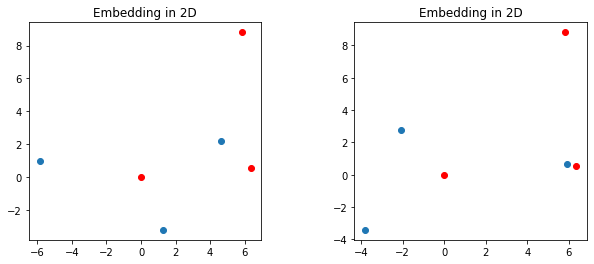

In [11]:
a2 = DM[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(S[1,0]*deltaX + S[1,1]*deltaY)
c2 = 2*(S[1,0]*deltaY - S[1,1]*deltaX)

a3 = DM[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(S[2,0]*deltaX + S[2,1]*deltaY)
c3 = 2*(S[2,0]*deltaY - S[2,1]*deltaX)

sinTheta = (a3*b2-a2*b3)/(b3*c2-b2*c3)
cosTheta = (a2*c3-a3*c2)/(b3*c2-b2*c3)

theta = np.arctan2(sinTheta,cosTheta)
print('Theta: %f' % (theta))
rotMatrix = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]]).T
F = np.array([[-1,0],[0,1]])
print(rotMatrix)
print(F)

S_real = (rotMatrix@MDS_transformed.T).T
print(S_real)
print(MDS_transformed)

fig = plt.figure(3, (10,4))
ax = fig.add_subplot(121)
plt.scatter(MDS_transformed[:,0], MDS_transformed[:,1])
plt.scatter(S[:,0], S[:,1], color='red')
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(122)
plt.scatter(S_real[:,0], S_real[:,1])
plt.scatter(S[:,0], S[:,1], color='red')
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()


In [12]:
print(S_real)
print(S)

[[-3.81771013 -3.41352145]
 [-2.10439107  2.73915951]
 [ 5.9221012   0.67436194]]
[[0.         0.        ]
 [6.36059761 0.53591989]
 [5.82261719 8.81118624]]
